In [1]:
!pip install egttools
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List
from tqdm import tqdm

from egttools.games import AbstractNPlayerGame
from egttools import sample_simplex, calculate_nb_states
from egttools.analytical import PairwiseComparison
from egttools.utils import calculate_stationary_distribution_non_hermitian
from egttools.plotting import draw_invasion_diagram

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import math
import numpy as np

def compf_compf(r,c, eps, group_size):
    return (r*c - c) - (eps/group_size)

def compf_d(f, r,c,eps, group_size ,k):
    F = (f%4)+1
    if k>=F:
        return ((r*c - c)/group_size - (eps/k))
    else:
        return 0

def d_compf(f, r,c,eps, group_size ,k):
    F = (f%5)+1
    if (group_size-k)>=F:
        return ((group_size-k)*r*c)/group_size
    else:
        return 0.0

def compf_c_or_free(f, r,c,eps, group_size ,k):
    return ((r*c - c) - (eps/k))

def free_compf(f, r,c,eps, group_size ,k):
    if(k == group_size):
        return 0.0
    else:
        return r*c - c
def C_compf_or_c(k,r, c):
    return r*c - c

def c_others(r,c,group_size,k):
    return ((r*k/group_size)-1)*c

def others_c(r,c,group_size,k):
    return ((group_size-k)*r*c)/group_size

def compf_fake(f, r,c,eps,delta,  group_size ,k,R):
    F_prime = math.ceil((f+1) / 5)
    if k >= F_prime:
        return (k*r*c/group_size)  - c - (eps/k) + ((group_size-k)*delta)/k
    else:
        return (1/R)*((k*r*c/group_size)  - c - (eps/k) + ((group_size-k)*delta)/k)
    
def fake_compf(f, r,c,eps,delta,  group_size ,k,R):
    F_prime = math.ceil((f+1) / 5)
    if k==5:
        return 0.0
    if (group_size - k) >= F_prime:
        return (((group_size-k)*r*c)/group_size) - delta
    else:
        return (1/R)*((((group_size-k)*r*c)/group_size) - delta)
    
def crd(type1, type2, k, group_size, c, r, eps, delta, R):
    if type1 <=24:
        if type2 <=24:
            return compf_compf(r,c, eps, group_size)
        elif type2 ==25 or type2 == 28:
            return compf_c_or_free(type1, r,c,eps, group_size ,k)
        elif type2 == 26:
            return compf_d(type1, r,c,eps, group_size ,k)
        elif type2== 27:
            return compf_fake(type1, r,c,eps,delta,  group_size ,k,R)
    elif type1 == 25:
        if type2<=24 or type2 == 25:
            return C_compf_or_c(k,r, c)
        else:
            return c_others(r,c,group_size,k)
        
    elif type1 == 26:
        if type2<=24:
            return d_compf(type2, r,c,eps, group_size ,k)
        elif type2 == 25:
            return others_c(r,c,group_size,k)
        else:
            return 0.0
    
    elif type1 == 27:
        if type2 <= 24:
            return fake_compf(type2, r,c,eps,delta,  group_size ,k,R)
        elif type2 == 25:
            return others_c(r,c,group_size,k)
        else:
            return 0.0
        
    elif type1 == 28:
        if type2 <= 24:
            return free_compf(type2, r,c,eps, group_size ,k)
        elif type2 == 25:
            return others_c(r,c,group_size,k)
        else:
            return 0.0



class EstimatePayoffsCRD(object):
    strategies =  ["COMP1_1", "COMP2_1", "COMP3_1", "COMP4_1", "COMP5_1",
            "COMP1_2", "COMP2_2", "COMP3_2", "COMP4_2", "COMP5_2",
            "COMP1_3", "COMP2_3", "COMP3_3", "COMP4_3", "COMP5_3",
            "COMP1_4", "COMP2_4", "COMP3_4", "COMP4_4", "COMP5_4",
            "COMP1_5", "COMP2_5", "COMP3_5", "COMP4_5", "COMP5_5",
            "C", "D", "FAKE", "FREE"]
    strategies_caller = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
    ns = len(strategies)

    @staticmethod
    def estimate_payoff(invader, resident, group_size, c, r, eps, delta, R):
        
        payoffs = []
        for i in range(1, int(group_size) + 1):

            avg = crd(invader, resident, i, group_size, c, r, eps, delta, R)
            payoffs.append(avg)

        # k is the number of invaders and z a dummy parameter
        return lambda k, z: payoffs[int(k) - 1]


    @staticmethod
    def estimate_payoffs(group_size, c, r, eps, delta, R):
        
            estimate = EstimatePayoffsCRD.estimate_payoff

            payoffs = np.asarray([[estimate(i, j, group_size, c, r, eps, delta, R)
                                   for j in EstimatePayoffsCRD.strategies_caller] for i in
                                  EstimatePayoffsCRD.strategies_caller])

            return payoffs

In [3]:
from egttools.analytical.sed_analytical import StochDynamics

In [25]:
c= 1
group_size = 5
r= 2
delta = 2
eps = 0.25
R = 100
Z = 100
mu = 0.0
beta = 0.25
payoff= EstimatePayoffsCRD.estimate_payoff(4,27,group_size, c, r, eps, delta, R)
print(payoff(1,group_size))
payoffs = EstimatePayoffsCRD.estimate_payoffs(group_size, c, r, eps, delta, R)

7.15


In [139]:
print(compf_fake(0, r,c,eps,delta,  group_size ,1,R))

0.25
0.25
8.0
7.15


In [70]:
sd = StochDynamics(EstimatePayoffsCRD.ns, payoffs, Z, group_size, mu=mu)
p_stationary_nu = sd.calculate_stationary_distribution(beta)
print(p_stationary_nu)


[9.50160514e-03 9.50176360e-03 9.51022053e-03 9.88676348e-03
 9.74969696e-02 9.50118342e-03 9.50122940e-03 9.50617002e-03
 1.17228048e-02 7.39527131e-02 9.50107035e-03 9.49781139e-03
 9.51017127e-03 1.07999420e-02 5.66558798e-02 9.49765934e-03
 9.50134449e-03 9.51004850e-03 1.01096947e-02 4.68669918e-02
 9.50110344e-03 9.50126189e-03 9.50971837e-03 9.88624355e-03
 9.74957391e-02 3.70241189e-02 3.94210265e-01 3.07119708e-04
 1.03239302e-03]


In [29]:
group_size = 5
c = 0.65
eps = 0.25
delta = 20
Z = 100  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
F_values = np.array([1,2,3,4,5])
R_values = np.array([2,5, 10, 20, 50, 100])
r_values = np.linspace(2.0, 5.0, 6)  # Example range for r


optimal_F_prime = np.zeros((len(r_values), len(R_values)))
avg_F_prime = np.zeros((len(r_values), len(R_values)))

for i, R in enumerate(R_values):
    for j, r in enumerate(r_values):
        optimal_F = np.zeros((5,), dtype = float)
        payoffs = EstimatePayoffsCRD.estimate_payoffs(group_size, c, r, eps, delta, R)
        game = StochDynamics(EstimatePayoffsCRD.ns, payoffs, Z, group_size, mu=mu)
        transition_matrix, _ = game.transition_and_fixation_matrix(beta)
        stationary_distribution = calculate_stationary_distribution_non_hermitian(transition_matrix.transpose())
        print(stationary_distribution)
        comp_1 = stationary_distribution[:5]
        comp_2 = stationary_distribution[5:10]
        comp_3 = stationary_distribution[10:15]
        comp_4 = stationary_distribution[15:20]
        comp_5 = stationary_distribution[20:25]
        avg_F_prime[j, i] = (1*sum(comp_1) + 2*sum(comp_2) +3*sum(comp_3) +4*sum(comp_4)+5*sum(comp_5))/sum(stationary_distribution[0:25])
        print("result")  
        print(avg_F_prime)
        optimal_F_prime[j, i] = np.argmax([sum(comp_1) / (len(comp_1)), sum(comp_2) / len(comp_2),sum(comp_3) / len(comp_3),sum(comp_4) / len(comp_1),sum(comp_5) / len(comp_1)]) +1
        print(optimal_F_prime)

[0.03570254 0.03570254 0.03570254 0.03570257 0.03570266 0.03570254
 0.03570254 0.03570254 0.03570257 0.03570266 0.03570254 0.03570254
 0.03570254 0.03570258 0.03570266 0.03570254 0.03570254 0.03570254
 0.03570258 0.03570266 0.03570254 0.03570254 0.03570254 0.03570257
 0.03570266 0.03583977 0.03571704 0.00016156 0.0357173 ]
result
[[3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[3. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[0.0367584  0.0367584  0.03675844 0.03675943 0.03676321 0.0367584
 0.0367584  0.03675843 0.0367597  0.03676322 0.0367584  0.03675839
 0.03675845 0.03675973 0.03676321 0.03675839 0.0367584  0.03675845
 0.03675962 0.03676319 0.0367584  0.0367584  0.03675844 0.03675943
 0.03676321 0.03817141 0.03680428 0.00013232 0.00590185]
result
[[3.         0.         0.         0.         0.         0.        ]
 [2.99999989 0

In [28]:
group_size = 5
c = 1.
eps = 0.25
delta = 20
Z = 100  # Population size
beta = 0.25  # Selection intensity
#R_values = np.logspace(2, 100 , 6)  # Example range for R
R_values = np.array([2,5, 10, 20, 50, 100])
R_values = np.array([1000])
r_values = np.linspace(2.0, 5.0, 6)  # Example range for r


optimal_F_prime = np.zeros((len(r_values), len(R_values)))
avg_F_prime = np.zeros((len(r_values), len(R_values)))

for i, R in enumerate(R_values):
    for j, r in enumerate(r_values):
        optimal_F = np.zeros((5,), dtype = float)
        payoffs = EstimatePayoffsCRD.estimate_payoffs(group_size, c, r, eps, delta, R)
        game = StochDynamics(EstimatePayoffsCRD.ns, payoffs, Z, group_size, mu=mu)
        stationary_distribution = game.calculate_stationary_distribution(beta)
        print(stationary_distribution)
        comp_1 = stationary_distribution[:5]
        comp_2 = stationary_distribution[5:10]
        comp_3 = stationary_distribution[10:15]
        comp_4 = stationary_distribution[15:20]
        comp_5 = stationary_distribution[20:25]
        avg_F_prime[j, i] = (1*sum(comp_1) + 2*sum(comp_2) +3*sum(comp_3) +4*sum(comp_4)+5*sum(comp_5))/sum(stationary_distribution[0:25])
        print("result")  
        print(avg_F_prime)
        optimal_F_prime[j, i] = np.argmax([sum(comp_1) / (len(comp_1)), sum(comp_2) / len(comp_2),sum(comp_3) / len(comp_3),sum(comp_4) / len(comp_1),sum(comp_5) / len(comp_1)]) +1
        print(optimal_F_prime)

[0.01026477 0.0102654  0.01028786 0.01126184 0.05168081 0.00889443
 0.00889484 0.00891005 0.01026259 0.05493529 0.00848089 0.00847829
 0.00850084 0.01003537 0.04793077 0.00837993 0.0083836  0.0084033
 0.00960773 0.04201301 0.00833851 0.00833902 0.00835757 0.00921533
 0.04773618 0.02024546 0.54339749 0.00114174 0.0073571 ]
result
[[2.90964819]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0.01060901 0.0106093  0.01062228 0.01118024 0.08253018 0.009425
 0.00942512 0.00943265 0.01122728 0.06913835 0.00906704 0.00906374
 0.00907913 0.01047163 0.05427823 0.00897881 0.00898269 0.00899413
 0.00977616 0.0452208  0.00894665 0.00894689 0.00895786 0.00944353
 0.07869479 0.0295826  0.44460375 0.00107674 0.00163543]
result
[[2.90964819]
 [2.9085867 ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
[0.0105336  0.01053374 0.01054184 0.01090657 0.10778407 0.00950177
 0.0095018  0.00950581 0.011

KeyboardInterrupt: 

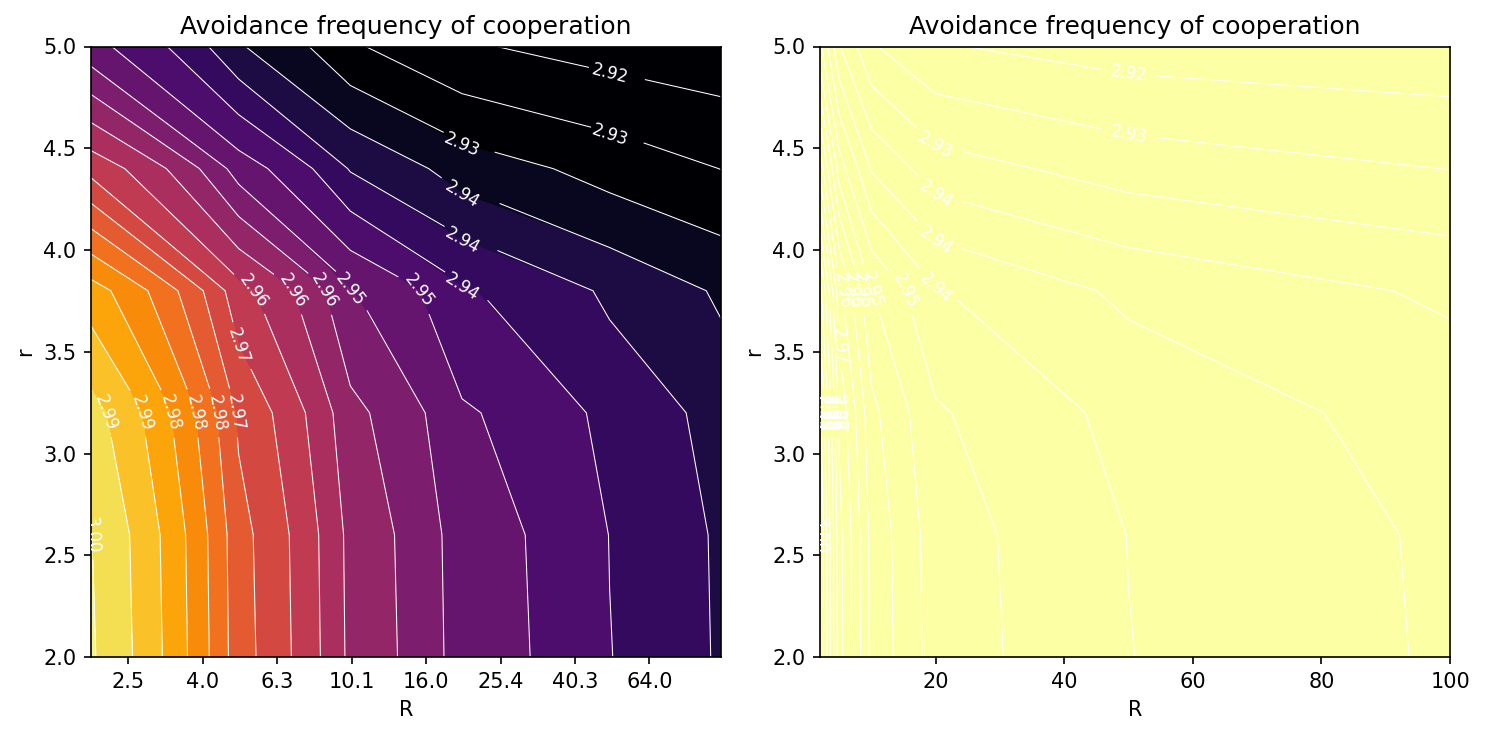

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

levels = np.linspace(2.92, 3., 21)

plt.figure(figsize=(10, 5), dpi=150)

# First graph: Avoidance frequency of cooperation
plt.subplot(1, 2, 1)
contour = plt.contourf(R_values, r_values, avg_F_prime.T, levels=levels, cmap='inferno', vmin=2.93, vmax=3.)
contour_lines = plt.contour(R_values, r_values, avg_F_prime.T, levels=levels, colors='white', linewidths=0.5)

plt.xscale('log', base=2**(1/3))  # Échelle logarithmique en base 2^(1/3)
plt.gca().xaxis.set_major_locator(LogLocator(base=2**(1/3), numticks=10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}"))
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel('R')
plt.ylabel("r")
plt.title("Avoidance frequency of cooperation")

# Second graph: Avoidance frequency of commitment
plt.subplot(1, 2, 2)
contour = plt.contourf(R_values, r_values, avg_F_prime.T, levels=levels, cmap='inferno', vmin=0., vmax=1.)
contour_lines = plt.contour(R_values, r_values, avg_F_prime.T, levels=levels, colors='white', linewidths=0.5)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt="%.2f")  
plt.xlabel('R')
plt.ylabel("r")
plt.title("Avoidance frequency of cooperation")


plt.tight_layout()
plt.show()